In [10]:
import xgboost as xgb
import lightgbm as lgb
import streamlit as st
import pandas as pd
import numpy as np
from graphviz import Digraph
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="Species")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def train_lightgbm(X, y):
    model = lgb.LGBMRegressor()
    model.fit(X, y)
    return model

lgb_model = train_lightgbm(X_train, y_train)

In [12]:
def xgb_tree_to_digraph(booster, tree_index):
    tree_dump = booster.get_dump()[tree_index]
    tree_lines = tree_dump.split("\n")

    G = Digraph()
    G.attr('node', shape='circle')

    for line in tree_lines:
        if line:
            node_info = line.split(":")
            node_id = node_info[0].strip()
            node_label = node_info[1].split("<")[0].strip()
            G.node(node_id, label=node_label)

            if len(node_info) > 2:
                children_info = node_info[2].strip().split(",")
                for child_info in children_info:
                    child_id, edge_label = child_info.split("<")
                    G.edge(node_id, child_id.strip(), label=edge_label.strip())
    return G

In [13]:
lgb_graph = lgb.create_tree_digraph(lgb_model.booster_, tree_index=0, orientation='vertical')
dot_source = lgb_graph.source

str(dot_source).splitlines()

['digraph {',
 '\tgraph [nodesep=0.05 rankdir=TB ranksep=0.3]',
 '\tsplit0 [label=<<B>petal_length_(cm)</B> &#8804;<B>3.150</B>> fillcolor=white shape=rectangle style=""]',
 '\tsplit3 [label=<<B>petal_length_(cm)</B> &#8804;<B>1.450</B>> fillcolor=white shape=rectangle style=""]',
 '\tleaf0 [label=<leaf 0: <B>0.892</B>>]',
 '\tsplit3 -> leaf0 [label=yes]',
 '\tleaf4 [label=<leaf 4: <B>0.897</B>>]',
 '\tsplit3 -> leaf4 [label=no]',
 '\tsplit0 -> split3 [label=yes]',
 '\tsplit1 [label=<<B>petal_length_(cm)</B> &#8804;<B>4.750</B>> fillcolor=white shape=rectangle style=""]',
 '\tleaf1 [label=<leaf 1: <B>0.995</B>>]',
 '\tsplit1 -> leaf1 [label=yes]',
 '\tsplit2 [label=<<B>petal_length_(cm)</B> &#8804;<B>5.350</B>> fillcolor=white shape=rectangle style=""]',
 '\tleaf2 [label=<leaf 2: <B>1.067</B>>]',
 '\tsplit2 -> leaf2 [label=yes]',
 '\tleaf3 [label=<leaf 3: <B>1.092</B>>]',
 '\tsplit2 -> leaf3 [label=no]',
 '\tsplit1 -> split2 [label=no]',
 '\tsplit0 -> split1 [label=no]',
 '}']

In [14]:
import re

dot_source = lgb_graph.source
source_lines = str(dot_source).splitlines()
# Remove 'digraph tree {'
source_lines.pop(0)
# Remove the closing brackets '}'
source_lines.pop(-1)

g = Digraph()

out = []
for i, line in enumerate(source_lines):
    line = line.strip()
    line = re.sub(r'\[\s?label=.*?\]', "", line)
    out.append(line)

g.body += out

In [15]:
out

['graph [nodesep=0.05 rankdir=TB ranksep=0.3]',
 'split0 ',
 'split3 ',
 'leaf0 ',
 'split3 -> leaf0 ',
 'leaf4 ',
 'split3 -> leaf4 ',
 'split0 -> split3 ',
 'split1 ',
 'leaf1 ',
 'split1 -> leaf1 ',
 'split2 ',
 'leaf2 ',
 'split2 -> leaf2 ',
 'leaf3 ',
 'split2 -> leaf3 ',
 'split1 -> split2 ',
 'split0 -> split1 ']

In [19]:
g.body

['graph [nodesep=0.05 rankdir=TB ranksep=0.3]',
 'split0 ',
 'split3 ',
 'leaf0 ',
 'split3 -> leaf0 ',
 'leaf4 ',
 'split3 -> leaf4 ',
 'split0 -> split3 ',
 'split1 ',
 'leaf1 ',
 'split1 -> leaf1 ',
 'split2 ',
 'leaf2 ',
 'split2 -> leaf2 ',
 'leaf3 ',
 'split2 -> leaf3 ',
 'split1 -> split2 ',
 'split0 -> split1 ']

In [17]:
for index, node in enumerate(g.body):
    if 'label' in node:
        # ラベル値をインデックスで置き換える
        new_label = f'label="{index}"'
        g.body[index] = re.sub(r'label=".*?"', new_label, node)

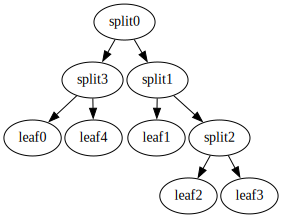

In [18]:
g

In [126]:
import re
from graphviz import Source, Digraph

booster = xgb_model.get_booster()
xgb_graph = xgb.to_graphviz(booster, num_trees=0)
dot_source = xgb_graph.source
g = Digraph()

source_lines = str(dot_source).splitlines()
# Remove 'digraph tree {'
source_lines.pop(0)
# Remove the closing brackets '}'
source_lines.pop(-1)

out = []
for line in source_lines:
    line = line.strip()
    line = re.sub(r'\[\s?label=".*?"\s?\]', "", line)
    out.append(line)

g.body += out

In [128]:
source_lines

['    graph [ rankdir=TB ]',
 '',
 '    0 [ label="petal length (cm)<2.45000005" ]',
 '    0 -> 1 [label="yes, missing" color="#0000FF"]',
 '    0 -> 2 [label="no" color="#FF0000"]',
 '',
 '    1 [ label="leaf=-0.146341473" ]',
 '',
 '    2 [ label="petal length (cm)<4.75" ]',
 '    2 -> 3 [label="yes, missing" color="#0000FF"]',
 '    2 -> 4 [label="no" color="#FF0000"]',
 '',
 '    3 [ label="leaf=0.153947383" ]',
 '',
 '    4 [ label="petal width (cm)<1.75" ]',
 '    4 -> 5 [label="yes, missing" color="#0000FF"]',
 '    4 -> 6 [label="no" color="#FF0000"]',
 '',
 '    5 [ label="petal length (cm)<4.94999981" ]',
 '    5 -> 7 [label="yes, missing" color="#0000FF"]',
 '    5 -> 8 [label="no" color="#FF0000"]',
 '',
 '    7 [ label="leaf=0.100000009" ]',
 '',
 '    8 [ label="petal width (cm)<1.6500001" ]',
 '    8 -> 9 [label="yes, missing" color="#0000FF"]',
 '    8 -> 10 [label="no" color="#FF0000"]',
 '',
 '    9 [ label="leaf=0.325000018" ]',
 '',
 '    10 [ label="leaf=0.07500000

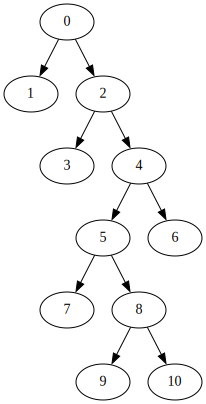

In [29]:
booster = xgb_model.get_booster()
xgb_graph = xgb.to_graphviz(booster, num_trees=0)
dot_source = xgb_graph.source

# # Create graphviz.Digraph object and set its source code
# digraph = Digraph()
# digraph.source = dot_source

# # Now you can work with digraph object as you wish
# print(digraph.source)

In [19]:
tree_lines

['0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1',
 '\t1:leaf=-0.0366289057',
 '\t2:[petal length (cm)<4.94999981] yes=3,no=4,missing=3',
 '\t\t3:[petal width (cm)<1.6500001] yes=5,no=6,missing=5',
 '\t\t\t5:[petal length (cm)<4.80000019] yes=7,no=8,missing=7',
 '\t\t\t\t7:leaf=0.0358643495',
 '\t\t\t\t8:leaf=0.0140399933',
 '\t\t\t6:[sepal width (cm)<3.0999999] yes=9,no=10,missing=9',
 '\t\t\t\t9:leaf=0.119132631',
 '\t\t\t\t10:leaf=-0.0557622164',
 '\t\t4:leaf=0.111998744',
 '']

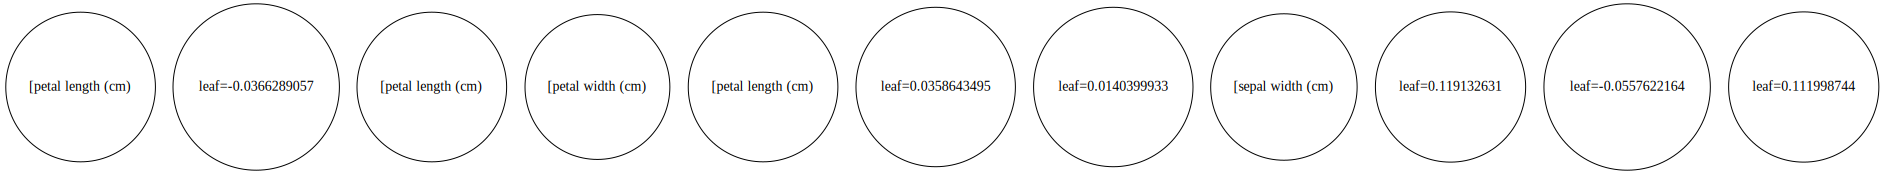

In [10]:
tree_index = 4
xgb_tree_to_digraph(xgb_model.get_booster(), tree_index)